<a href="https://colab.research.google.com/github/giangdip2410/Research-Stuff/blob/main/CPSC5440_Assigment4_JGM667.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Introduction to LSTM**

**In this notebook, I will build a character-level RNN/LSTM/GRU with PyTorch. The models will be able to generate new text based on the text from the book. The book called Grimms' Fairy Tales by Jacob Grimm and Wilhelm Grimm. Datasets available at: https://www.kaggle.com/datasets/tschomacker/grimms-fairy-tales**

### Library 

In [ ]:
from collections import defaultdict
import copy
import random
import os
import shutil
from urllib.request import urlretrieve
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from multiprocessing import Pool
cudnn.benchmark = True
from torchsummary import summary
import pickle
import pandas as pd
import time
import random

In [ ]:
#fix seed for stable training
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

### Config

In [ ]:
LEANRING_RATE = 0.001
#device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
epochs = 30

### Data Preporcessing

In [ ]:
#read data
df_text = pd.read_csv("grimms_fairytales.csv")
list_all_text = []
for i in range(df_text.shape[0]):
  list_all_text.append(df_text['Text'][i])
#get all stories 
text = " ".join(list_all_text)

In [ ]:
#drop new line mask
text = text.replace("\n", "")

In [ ]:
#int2char, which maps integers to characters ; char2int, which maps characters to unique integers
chars = tuple(set(text))
int2char = dict(enumerate(chars))
char2int = {ch: ii for ii, ch in int2char.items()}
#encode char to interge
encoded = np.array([char2int[ch] for ch in text])

In [ ]:
# one-hot encoded for each character 
def one_hot_encode(arr, n_labels):
    
    # Initialize the the encoded array
    one_hot = np.zeros((np.multiply(*arr.shape), n_labels), dtype=np.float32)
    
    # Fill the appropriate elements with ones
    one_hot[np.arange(one_hot.shape[0]), arr.flatten()] = 1.
    
    # Finally reshape it to get back to the original array
    one_hot = one_hot.reshape((*arr.shape, n_labels))
    
    return one_hot

In [ ]:
# get data batch
def get_batches(arr, n_seqs, n_steps):
    '''Create a generator that returns batches of size
       n_seqs x n_steps from arr.
       
       Arguments
       ---------
       arr: Array you want to make batches from
       n_seqs: Batch size, the number of sequences per batch
       n_steps: Number of sequence steps per batch
    '''
    
    batch_size = n_seqs * n_steps
    n_batches = len(arr)//batch_size
    
    # Keep only enough characters to make full batches
    arr = arr[:n_batches * batch_size]
    # Reshape into n_seqs rows
    arr = arr.reshape((n_seqs, -1))
    
    for n in range(0, arr.shape[1], n_steps):
        # The features
        x = arr[:, n:n+n_steps]
        # The targets, shifted by one
        y = np.zeros_like(x)
        try:
            y[:, :-1], y[:, -1] = x[:, 1:], arr[:, n+n_steps]
        except IndexError:
            y[:, :-1], y[:, -1] = x[:, 1:], arr[:, 0]
        yield x, y

### Build Model

In [ ]:
class LSTM(nn.Module):
    
    def __init__(self, tokens, device, n_steps=100, n_hidden=256, n_layers=2, drop_prob=0.3):
        super().__init__()
        self.drop_prob = drop_prob
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.device = device

        # creating character dictionaries
        self.chars = tokens
        self.int2char = dict(enumerate(self.chars))
        self.char2int = {ch: ii for ii, ch in self.int2char.items()}
        
        ## the LSTM
        self.lstm = nn.LSTM(len(self.chars), n_hidden, n_layers, 
                            dropout=drop_prob, batch_first=True)
        
        ##  dropout layer
        self.dropout = nn.Dropout(drop_prob)
        
        ## fully-connected output layer
        self.fc = nn.Linear(n_hidden, len(self.chars))
        
        # initialize the weights
        self.init_weights()
      
    
    def forward(self, x, hc):
        ''' Forward pass through the network. 
            These inputs are x, and the hidden/cell state `hc`. '''
        
        ## Get x, and the new hidden state (h, c) from the lstm
        x, (h, c) = self.lstm(x, hc)
        
        ## pass x through a droupout layer
        x = self.dropout(x)
        
        # Stack up LSTM outputs using view
        x = x.reshape(x.size()[0]*x.size()[1], self.n_hidden)
        
        ## put x through the fully-connected layer
        x = self.fc(x)
        
        # return x and the hidden state (h, c)
        return x, (h, c)
    
    def predict(self, char, h=None, device=device, top_k=5):
      ''' Given a character, predict the next character.
      
          Returns the predicted character and the hidden state.
      '''
      
      
      if h is None:
          h = self.init_hidden(1)
      
      x = np.array([[self.char2int[char]]])
      x = one_hot_encode(x, len(self.chars))
      inputs = torch.from_numpy(x)
      inputs = inputs.to(device)
      
      h = tuple([each.data for each in h])
      out, h = self.forward(inputs, h)

      p = F.softmax(out, dim=1).data
      p = p.to(device)
      
      if top_k is None:
          top_ch = np.arange(len(self.chars))
      else:
          p, top_ch = p.topk(top_k)
          top_ch = top_ch.cpu().numpy().squeeze()
      
      p = p.cpu().numpy().squeeze()
      char = np.random.choice(top_ch, p=p/p.sum())
          
      return self.int2char[char], h
    
    def init_weights(self):
        ''' Initialize weights for fully connected layer '''
        initrange = 0.1
        
        # Set bias tensor to all zeros
        self.fc.bias.data.fill_(0)
        # FC weights as random uniform
        self.fc.weight.data.uniform_(-1, 1)
        
    def init_hidden(self, n_seqs):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x n_seqs x n_hidden,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        return (weight.new(self.n_layers, n_seqs, self.n_hidden).zero_(),
                weight.new(self.n_layers, n_seqs, self.n_hidden).zero_())

In [ ]:
# define and print the model
model = LSTM(chars, device, n_hidden=512, n_layers=2)
print(model)

LSTM(
  (lstm): LSTM(77, 512, num_layers=2, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=512, out_features=77, bias=True)
)


In [ ]:
#optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEANRING_RATE)
#loss function
criterion = nn.CrossEntropyLoss()

### Training function

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
def train(model, data, epochs=epochs, n_seqs=10, n_steps=50, opt=optimizer, criterion=criterion, device=device):
    ''' 
    Training a text generation network 
    '''
    list_train_loss = []
    list_val_loss = []
    model.train()
    
    # create training and validation data
    val_frac = 0.1 # ratio train/val
    print_every = 50 #logging each n steps
    clip = 5 # gradient clipping
    best_valid_loss = float('inf') # best valid loss
    val_idx = int(len(data)*(1-val_frac))
    data, val_data = data[:val_idx], data[val_idx:]
    
    model.to(device)
    
    n_chars = len(model.chars)
    for e in tqdm(range(epochs)):
        start_time = time.monotonic()
        h = model.init_hidden(n_seqs)
        for x, y in get_batches(data, n_seqs, n_steps):
        
            # One-hot encode our data and make them Torch tensors
            x = one_hot_encode(x, n_chars)
            inputs, targets = torch.from_numpy(x), torch.from_numpy(y)
            
            inputs, targets = inputs.to(device), targets.to(device)

            # Creating new variables for the hidden state, otherwise
            # we'd backprop through the entire training history
            
            h = tuple([each.data for each in h])

            model.zero_grad()
            
            output, h = model.forward(inputs, h)
            loss = criterion(output, targets.view(n_seqs*n_steps))

            loss.backward()
            
            # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            nn.utils.clip_grad_norm_(model.parameters(), clip)

            opt.step()
              
        # validation
        val_h = model.init_hidden(n_seqs)
        val_losses = []
        for x, y in get_batches(val_data, n_seqs, n_steps):
            # One-hot encode our data and make them Torch tensors
            x = one_hot_encode(x, n_chars)
            x, y = torch.from_numpy(x), torch.from_numpy(y)
            
            # Creating new variables for the hidden state, otherwise
            # we'd backprop through the entire training history
            val_h = tuple([each.data for each in val_h])
            
            inputs, targets = x, y
            inputs, targets = inputs.to(device), targets.to(device)

            output, val_h = model.forward(inputs, val_h)
            val_loss = criterion(output, targets.view(n_seqs*n_steps))
        # save training and validation loss
        val_losses.append(val_loss.item())
        list_train_loss.append(loss.item())
        list_val_loss.append(np.mean(val_losses))
        #save best model
        if np.mean(val_losses) < best_valid_loss:
            best_valid_loss = np.mean(val_losses)
            torch.save(model.state_dict(), 'best-LSTM-model.pt')
        end_time = time.monotonic()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        print(f'\n Epoch: {e+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {loss.item():.3f} ')
        print(f'\t Val. Loss: {np.mean(val_losses):.3f} ')
    return list_train_loss, list_val_loss

### Start Training

In [ ]:
#training model
n_seqs, n_steps = 128, 100
list_train_loss, list_val_loss = train(model, encoded,  n_seqs=n_seqs, n_steps=n_steps)

  3%|▎         | 1/30 [00:03<01:49,  3.77s/it]


 Epoch: 01 | Epoch Time: 0m 3s
	Train Loss: 2.825 
	 Val. Loss: 2.798 


  7%|▋         | 2/30 [00:06<01:35,  3.42s/it]


 Epoch: 02 | Epoch Time: 0m 3s
	Train Loss: 2.366 
	 Val. Loss: 2.319 


 10%|█         | 3/30 [00:10<01:30,  3.37s/it]


 Epoch: 03 | Epoch Time: 0m 3s
	Train Loss: 2.208 
	 Val. Loss: 2.163 


 13%|█▎        | 4/30 [00:13<01:24,  3.25s/it]


 Epoch: 04 | Epoch Time: 0m 3s
	Train Loss: 2.111 
	 Val. Loss: 2.060 


 17%|█▋        | 5/30 [00:16<01:19,  3.19s/it]


 Epoch: 05 | Epoch Time: 0m 3s
	Train Loss: 2.024 
	 Val. Loss: 1.989 


 20%|██        | 6/30 [00:19<01:15,  3.15s/it]


 Epoch: 06 | Epoch Time: 0m 3s
	Train Loss: 1.953 
	 Val. Loss: 1.918 


 23%|██▎       | 7/30 [00:22<01:12,  3.14s/it]


 Epoch: 07 | Epoch Time: 0m 3s
	Train Loss: 1.900 
	 Val. Loss: 1.881 


 27%|██▋       | 8/30 [00:25<01:08,  3.13s/it]


 Epoch: 08 | Epoch Time: 0m 3s
	Train Loss: 1.829 
	 Val. Loss: 1.818 


 30%|███       | 9/30 [00:28<01:05,  3.12s/it]


 Epoch: 09 | Epoch Time: 0m 3s
	Train Loss: 1.789 
	 Val. Loss: 1.780 


 33%|███▎      | 10/30 [00:31<01:02,  3.12s/it]


 Epoch: 10 | Epoch Time: 0m 3s
	Train Loss: 1.736 
	 Val. Loss: 1.732 


 37%|███▋      | 11/30 [00:35<00:59,  3.13s/it]


 Epoch: 11 | Epoch Time: 0m 3s
	Train Loss: 1.701 
	 Val. Loss: 1.709 


 40%|████      | 12/30 [00:38<00:56,  3.13s/it]


 Epoch: 12 | Epoch Time: 0m 3s
	Train Loss: 1.657 
	 Val. Loss: 1.676 


 43%|████▎     | 13/30 [00:41<00:53,  3.14s/it]


 Epoch: 13 | Epoch Time: 0m 3s
	Train Loss: 1.622 
	 Val. Loss: 1.643 


 47%|████▋     | 14/30 [00:44<00:50,  3.14s/it]


 Epoch: 14 | Epoch Time: 0m 3s
	Train Loss: 1.593 
	 Val. Loss: 1.620 


 50%|█████     | 15/30 [00:47<00:47,  3.14s/it]


 Epoch: 15 | Epoch Time: 0m 3s
	Train Loss: 1.557 
	 Val. Loss: 1.606 


 53%|█████▎    | 16/30 [00:50<00:44,  3.15s/it]


 Epoch: 16 | Epoch Time: 0m 3s
	Train Loss: 1.529 
	 Val. Loss: 1.581 


 57%|█████▋    | 17/30 [00:54<00:41,  3.16s/it]


 Epoch: 17 | Epoch Time: 0m 3s
	Train Loss: 1.498 
	 Val. Loss: 1.559 


 60%|██████    | 18/30 [00:57<00:37,  3.17s/it]


 Epoch: 18 | Epoch Time: 0m 3s
	Train Loss: 1.478 
	 Val. Loss: 1.544 


 63%|██████▎   | 19/30 [01:00<00:34,  3.15s/it]


 Epoch: 19 | Epoch Time: 0m 3s
	Train Loss: 1.450 
	 Val. Loss: 1.544 


 67%|██████▋   | 20/30 [01:03<00:31,  3.17s/it]


 Epoch: 20 | Epoch Time: 0m 3s
	Train Loss: 1.428 
	 Val. Loss: 1.527 


 70%|███████   | 21/30 [01:06<00:28,  3.16s/it]


 Epoch: 21 | Epoch Time: 0m 3s
	Train Loss: 1.406 
	 Val. Loss: 1.517 


 73%|███████▎  | 22/30 [01:09<00:25,  3.16s/it]


 Epoch: 22 | Epoch Time: 0m 3s
	Train Loss: 1.387 
	 Val. Loss: 1.503 


 77%|███████▋  | 23/30 [01:12<00:22,  3.15s/it]


 Epoch: 23 | Epoch Time: 0m 3s
	Train Loss: 1.373 
	 Val. Loss: 1.501 


 80%|████████  | 24/30 [01:16<00:18,  3.16s/it]


 Epoch: 24 | Epoch Time: 0m 3s
	Train Loss: 1.345 
	 Val. Loss: 1.495 


 83%|████████▎ | 25/30 [01:19<00:15,  3.17s/it]


 Epoch: 25 | Epoch Time: 0m 3s
	Train Loss: 1.330 
	 Val. Loss: 1.488 


 87%|████████▋ | 26/30 [01:22<00:12,  3.16s/it]


 Epoch: 26 | Epoch Time: 0m 3s
	Train Loss: 1.305 
	 Val. Loss: 1.502 


 90%|█████████ | 27/30 [01:25<00:09,  3.15s/it]


 Epoch: 27 | Epoch Time: 0m 3s
	Train Loss: 1.290 
	 Val. Loss: 1.489 


 93%|█████████▎| 28/30 [01:28<00:06,  3.14s/it]


 Epoch: 28 | Epoch Time: 0m 3s
	Train Loss: 1.273 
	 Val. Loss: 1.491 


 97%|█████████▋| 29/30 [01:32<00:03,  3.21s/it]


 Epoch: 29 | Epoch Time: 0m 3s
	Train Loss: 1.261 
	 Val. Loss: 1.485 


100%|██████████| 30/30 [01:35<00:00,  3.18s/it]


 Epoch: 30 | Epoch Time: 0m 3s
	Train Loss: 1.239 
	 Val. Loss: 1.479 


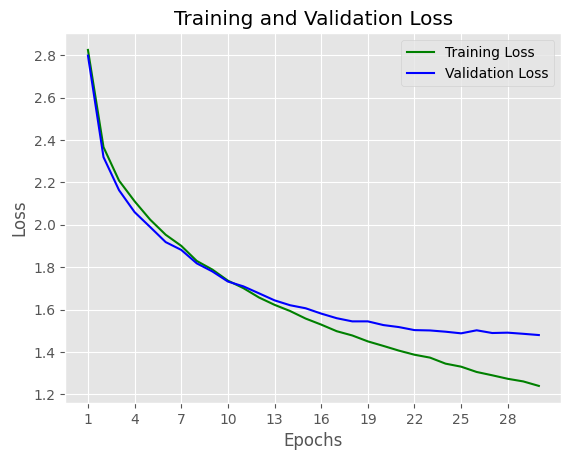

In [ ]:
# plot training & validation loss
n_epochs = range(1, epochs+1)
 
# Plot and label the training and validation loss values
# Use our custom style
plt.style.use('ggplot')
plt.plot(n_epochs, list_train_loss, 'g', label='Training Loss')
plt.plot(n_epochs, list_val_loss,  'b', label='Validation Loss')
 
# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
 
# Set the tick locations
plt.xticks(range(1, epochs+1, 3))
 
# Display the plot
plt.legend(loc='best')
plt.show()

**Both Training loss and validation loss gradually descrease, it shows that model learning process is effective.**

### Text Generation

In [ ]:
# load the best checkpoint
model.load_state_dict(torch.load('best-LSTM-model.pt'))

<All keys matched successfully>

In [ ]:
def text_generation(model, seq_length, input_text='a'):
    """
    Funcion to generate new character using trained deep model
    """
    model.eval()
    
    # First off, run through the prime characters
    chars = [ch for ch in input_text]
    h = model.init_hidden(1)
    for ch in input_text:
        char, h = model.predict(ch, h)

    chars.append(char)
    
    # Now pass in the previous character and get a new one
    for ii in range(seq_length):
        char, h = model.predict(chars[-1], h)
        chars.append(char)

    return ''.join(chars)

In [ ]:
generate_text = text_generation(model, seq_length=500, input_text='story')

In [ ]:
generate_text

'story winders; and as they were all sones towards to get out together for a bird singing, and was so to she had as tookingdown his wife; andhas she said tohimself, ‘If I can that was back to mark as have to stands.’ Then he went and looked another husband, but had brought in the child of the bride and croess. They said the peasants were all that he wished how it aspones that they could so, then he will go hometo her wood. Then the father had sicked a little sprong, help takeread any still the were to '

**Generating text results are quite good since the results are very closed with true store. It proves that LSTM model is very good for sequene data.**

### GRU Model

In [ ]:
class GRU(nn.Module):
    
    def __init__(self, tokens, device, n_steps=100, n_hidden=256, n_layers=2, drop_prob=0.3):
        super().__init__()
        self.drop_prob = drop_prob
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.device = device

        # creating character dictionaries
        self.chars = tokens
        self.int2char = dict(enumerate(self.chars))
        self.char2int = {ch: ii for ii, ch in self.int2char.items()}
        
        ## the GRU
        self.gru = nn.GRU(len(self.chars), n_hidden, n_layers, 
                            dropout=drop_prob, batch_first=True)
        
        ##  dropout layer
        self.dropout = nn.Dropout(drop_prob)
        
        ## fully-connected output layer
        self.fc = nn.Linear(n_hidden, len(self.chars))
        
        # initialize the weights
        self.init_weights()
      
    
    def forward(self, x, hc):
        ''' Forward pass through the network. 
            These inputs are x, and the hidden/cell state `hc`. '''
        
        ## Get x, and the new hidden state (h, c) from the lstm
        x, h = self.gru(x, hc)
        
        ## pass x through a droupout layer
        x = self.dropout(x)
        
        # Stack up GRU outputs using view
        x = x.reshape(x.size()[0]*x.size()[1], self.n_hidden)
        
        ## put x through the fully-connected layer
        x = self.fc(x)
        
        # return x and the hidden state h
        return x, h
    
    def predict(self, char, h=None, device=device, top_k=5):
      ''' Given a character, predict the next character.
      
          Returns the predicted character and the hidden state.
      '''
      
      
      if h is None:
          h = self.init_hidden(1)
      
      x = np.array([[self.char2int[char]]])
      x = one_hot_encode(x, len(self.chars))
      inputs = torch.from_numpy(x)
      inputs = inputs.to(device)
      
      h = h.data
      h = h.to(device)
     
      out, h = self.forward(inputs, h)

      p = F.softmax(out, dim=1).data
      p = p.to(device)
      
      if top_k is None:
          top_ch = np.arange(len(self.chars))
      else:
          p, top_ch = p.topk(top_k)
          top_ch = top_ch.cpu().numpy().squeeze()
      
      p = p.cpu().numpy().squeeze()
      char = np.random.choice(top_ch, p=p/p.sum())
          
      return self.int2char[char], h
    
    def init_weights(self):
        ''' Initialize weights for fully connected layer '''
        initrange = 0.1
        
        # Set bias tensor to all zeros
        self.fc.bias.data.fill_(0)
        # FC weights as random uniform
        self.fc.weight.data.uniform_(-1, 1)
        
    def init_hidden(self, n_seqs):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x n_seqs x n_hidden,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        return weight.new(self.n_layers, n_seqs, self.n_hidden).zero_()#, #weight.new(self.n_layers, n_seqs, self.n_hidden).zero_())

In [ ]:
# define and print the model
model = GRU(chars, device, n_hidden=512, n_layers=2)
model = model.to(device)
print(model)

GRU(
  (gru): GRU(77, 512, num_layers=2, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=512, out_features=77, bias=True)
)


In [ ]:
#optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEANRING_RATE)
#loss function
criterion = nn.CrossEntropyLoss()

In [ ]:
def train_gru(model, data, epochs=epochs, n_seqs=10, n_steps=50, opt=optimizer, criterion=criterion, device=device):
    ''' 
    Training a text generation network 
    '''
    list_train_loss = []
    list_val_loss = []
    model.train()
    
    # create training and validation data
    val_frac = 0.1 # ratio train/val
    print_every = 50 #logging each n steps
    clip = 5 # gradient clipping
    best_valid_loss = float('inf') # best valid loss
    val_idx = int(len(data)*(1-val_frac))
    data, val_data = data[:val_idx], data[val_idx:]
    
    model.to(device)
    
    n_chars = len(model.chars)
    for e in tqdm(range(epochs)):
        start_time = time.monotonic()
        h = model.init_hidden(n_seqs)
      
        for x, y in get_batches(data, n_seqs, n_steps):
        
            # One-hot encode our data and make them Torch tensors
            x = one_hot_encode(x, n_chars)
            inputs, targets = torch.from_numpy(x), torch.from_numpy(y)
            
            inputs, targets = inputs.to(device), targets.to(device)

            # Creating new variables for the hidden state, otherwise
            # we'd backprop through the entire training history
            h = h.data

            model.zero_grad()
            
            output, h = model.forward(inputs, h)
            loss = criterion(output, targets.view(n_seqs*n_steps))

            loss.backward()
            
            # clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            nn.utils.clip_grad_norm_(model.parameters(), clip)

            opt.step()
              
        # validation
        val_h = model.init_hidden(n_seqs)
        val_losses = []
        for x, y in get_batches(val_data, n_seqs, n_steps):
            # One-hot encode our data and make them Torch tensors
            x = one_hot_encode(x, n_chars)
            x, y = torch.from_numpy(x), torch.from_numpy(y)
            
            # Creating new variables for the hidden state, otherwise
            # we'd backprop through the entire training history
            # val_h = tuple([each.data for each in val_h])
            val_h = val_h.data
            
            inputs, targets = x, y
            inputs, targets = inputs.to(device), targets.to(device)

            output, val_h = model.forward(inputs, val_h)
            val_loss = criterion(output, targets.view(n_seqs*n_steps))
        # save training and validation loss
        val_losses.append(val_loss.item())
        list_train_loss.append(loss.item())
        list_val_loss.append(np.mean(val_losses))
        #save best model
        if np.mean(val_losses) < best_valid_loss:
            best_valid_loss = np.mean(val_losses)
            torch.save(model.state_dict(), 'best-GRU-model.pt')
        end_time = time.monotonic()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        print(f'\n Epoch: {e+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {loss.item():.3f} ')
        print(f'\t Val. Loss: {np.mean(val_losses):.3f} ')
    return list_train_loss, list_val_loss

In [ ]:
#training model
n_seqs, n_steps = 128, 100
list_train_loss, list_val_loss = train_gru(model, encoded, n_seqs=n_seqs, n_steps=n_steps)

  3%|▎         | 1/30 [00:02<01:16,  2.65s/it]


 Epoch: 01 | Epoch Time: 0m 2s
	Train Loss: 2.468 
	 Val. Loss: 2.408 


  7%|▋         | 2/30 [00:05<01:14,  2.65s/it]


 Epoch: 02 | Epoch Time: 0m 2s
	Train Loss: 2.230 
	 Val. Loss: 2.176 


 10%|█         | 3/30 [00:07<01:11,  2.66s/it]


 Epoch: 03 | Epoch Time: 0m 2s
	Train Loss: 2.131 
	 Val. Loss: 2.082 


 13%|█▎        | 4/30 [00:10<01:09,  2.66s/it]


 Epoch: 04 | Epoch Time: 0m 2s
	Train Loss: 2.059 
	 Val. Loss: 2.011 


 17%|█▋        | 5/30 [00:13<01:06,  2.67s/it]


 Epoch: 05 | Epoch Time: 0m 2s
	Train Loss: 1.988 
	 Val. Loss: 1.945 


 20%|██        | 6/30 [00:15<01:03,  2.67s/it]


 Epoch: 06 | Epoch Time: 0m 2s
	Train Loss: 1.926 
	 Val. Loss: 1.894 


 23%|██▎       | 7/30 [00:18<01:01,  2.67s/it]


 Epoch: 07 | Epoch Time: 0m 2s
	Train Loss: 1.859 
	 Val. Loss: 1.846 


 27%|██▋       | 8/30 [00:21<00:58,  2.68s/it]


 Epoch: 08 | Epoch Time: 0m 2s
	Train Loss: 1.812 
	 Val. Loss: 1.805 


 30%|███       | 9/30 [00:24<00:56,  2.68s/it]


 Epoch: 09 | Epoch Time: 0m 2s
	Train Loss: 1.765 
	 Val. Loss: 1.768 


 33%|███▎      | 10/30 [00:26<00:53,  2.69s/it]


 Epoch: 10 | Epoch Time: 0m 2s
	Train Loss: 1.728 
	 Val. Loss: 1.734 


 37%|███▋      | 11/30 [00:29<00:51,  2.69s/it]


 Epoch: 11 | Epoch Time: 0m 2s
	Train Loss: 1.686 
	 Val. Loss: 1.713 


 40%|████      | 12/30 [00:32<00:48,  2.69s/it]


 Epoch: 12 | Epoch Time: 0m 2s
	Train Loss: 1.663 
	 Val. Loss: 1.677 


 43%|████▎     | 13/30 [00:34<00:45,  2.69s/it]


 Epoch: 13 | Epoch Time: 0m 2s
	Train Loss: 1.624 
	 Val. Loss: 1.657 


 47%|████▋     | 14/30 [00:37<00:43,  2.70s/it]


 Epoch: 14 | Epoch Time: 0m 2s
	Train Loss: 1.596 
	 Val. Loss: 1.640 


 50%|█████     | 15/30 [00:40<00:40,  2.70s/it]


 Epoch: 15 | Epoch Time: 0m 2s
	Train Loss: 1.573 
	 Val. Loss: 1.624 


 53%|█████▎    | 16/30 [00:42<00:37,  2.70s/it]


 Epoch: 16 | Epoch Time: 0m 2s
	Train Loss: 1.550 
	 Val. Loss: 1.605 


 57%|█████▋    | 17/30 [00:45<00:35,  2.70s/it]


 Epoch: 17 | Epoch Time: 0m 2s
	Train Loss: 1.527 
	 Val. Loss: 1.592 


 60%|██████    | 18/30 [00:48<00:32,  2.71s/it]


 Epoch: 18 | Epoch Time: 0m 2s
	Train Loss: 1.517 
	 Val. Loss: 1.571 


 63%|██████▎   | 19/30 [00:51<00:29,  2.70s/it]


 Epoch: 19 | Epoch Time: 0m 2s
	Train Loss: 1.486 
	 Val. Loss: 1.558 


 67%|██████▋   | 20/30 [00:53<00:27,  2.71s/it]


 Epoch: 20 | Epoch Time: 0m 2s
	Train Loss: 1.468 
	 Val. Loss: 1.552 


 70%|███████   | 21/30 [00:56<00:24,  2.70s/it]


 Epoch: 21 | Epoch Time: 0m 2s
	Train Loss: 1.452 
	 Val. Loss: 1.552 


 73%|███████▎  | 22/30 [00:59<00:21,  2.71s/it]


 Epoch: 22 | Epoch Time: 0m 2s
	Train Loss: 1.436 
	 Val. Loss: 1.533 


 77%|███████▋  | 23/30 [01:01<00:19,  2.72s/it]


 Epoch: 23 | Epoch Time: 0m 2s
	Train Loss: 1.421 
	 Val. Loss: 1.528 


 80%|████████  | 24/30 [01:04<00:16,  2.72s/it]


 Epoch: 24 | Epoch Time: 0m 2s
	Train Loss: 1.400 
	 Val. Loss: 1.519 


 83%|████████▎ | 25/30 [01:07<00:13,  2.70s/it]


 Epoch: 25 | Epoch Time: 0m 2s
	Train Loss: 1.386 
	 Val. Loss: 1.520 


 87%|████████▋ | 26/30 [01:10<00:10,  2.71s/it]


 Epoch: 26 | Epoch Time: 0m 2s
	Train Loss: 1.365 
	 Val. Loss: 1.510 


 90%|█████████ | 27/30 [01:12<00:08,  2.71s/it]


 Epoch: 27 | Epoch Time: 0m 2s
	Train Loss: 1.358 
	 Val. Loss: 1.508 


 93%|█████████▎| 28/30 [01:15<00:05,  2.72s/it]


 Epoch: 28 | Epoch Time: 0m 2s
	Train Loss: 1.344 
	 Val. Loss: 1.502 


 97%|█████████▋| 29/30 [01:18<00:02,  2.73s/it]


 Epoch: 29 | Epoch Time: 0m 2s
	Train Loss: 1.330 
	 Val. Loss: 1.501 


100%|██████████| 30/30 [01:20<00:00,  2.70s/it]


 Epoch: 30 | Epoch Time: 0m 2s
	Train Loss: 1.319 
	 Val. Loss: 1.513 


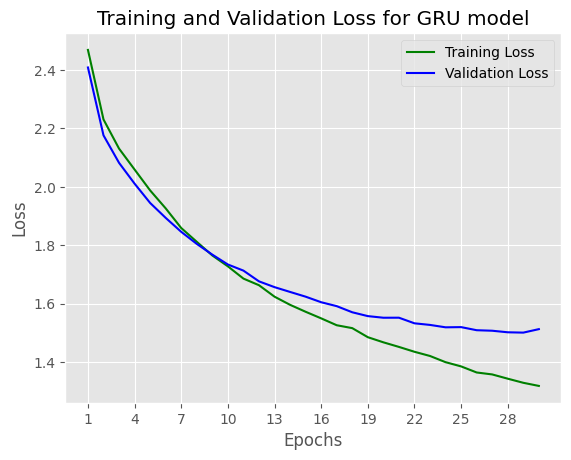

In [ ]:
# plot training & validation loss
n_epochs = range(1, epochs+1)
 
# Plot and label the training and validation loss values
# Use our custom style
plt.style.use('ggplot')
plt.plot(n_epochs, list_train_loss, 'g', label='Training Loss')
plt.plot(n_epochs, list_val_loss,  'b', label='Validation Loss')
 
# Add in a title and axes labels
plt.title('Training and Validation Loss for GRU model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
 
# Set the tick locations
plt.xticks(range(1, epochs+1, 3))
 
# Display the plot
plt.legend(loc='best')
plt.show()

**Comparing to LSTM model, GRU model loss slightly increases: from: 1.479 to 1.513**

#### Text Generation using GRU

In [ ]:
# load the best checkpoint
model.load_state_dict(torch.load('best-GRU-model.pt'))

<All keys matched successfully>

In [ ]:
generate_text = text_generation(model, seq_length=500, input_text='story')

In [ ]:
generate_text

'story we that all sister on,but he wished to hear and crossed his word four huntsman. ‘Ah! would be all were aring, and as he should be seen for the tailor. When the well plated that he was to see the boat, and happened, that the father went totheir first. ‘And you were something with me to heapt as have breen the forest the stood, and set over he was asked him word to say, and she were to live and was asked how it, and therower she had saded asked him what the feast asked him for a sold, which saw th'

**Comparing with LSTM model, GRU model is less complexity but the text generating result is still quite good.**

### RNN Model

In [ ]:
class RNN(nn.Module):
    
    def __init__(self, tokens, device, n_steps=100, n_hidden=256, n_layers=2, drop_prob=0.3):
        super().__init__()
        self.drop_prob = drop_prob
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.device = device

        # creating character dictionaries
        self.chars = tokens
        self.int2char = dict(enumerate(self.chars))
        self.char2int = {ch: ii for ii, ch in self.int2char.items()}
        
        ## the RNN
        self.rnn = nn.RNN(len(self.chars), n_hidden, n_layers, 
                            dropout=drop_prob, batch_first=True)
        
        ##  dropout layer
        self.dropout = nn.Dropout(drop_prob)
        
        ## fully-connected output layer
        self.fc = nn.Linear(n_hidden, len(self.chars))
        
        # initialize the weights
        self.init_weights()
      
    
    def forward(self, x, hc):
        ''' Forward pass through the network. 
            These inputs are x, and the hidden/cell state `hc`. '''
        
        ## Get x, and the new hidden state (h, c) from the lstm
        x, h = self.rnn(x, hc)
        
        ## pass x through a droupout layer
        x = self.dropout(x)
        
        # Stack up GRU outputs using view
        x = x.reshape(x.size()[0]*x.size()[1], self.n_hidden)
        
        ## put x through the fully-connected layer
        x = self.fc(x)
        
        # return x and the hidden state h
        return x, h
    
    def predict(self, char, h=None, device=device, top_k=5):
      ''' Given a character, predict the next character.
      
          Returns the predicted character and the hidden state.
      '''
      
      
      if h is None:
          h = self.init_hidden(1)
      
      x = np.array([[self.char2int[char]]])
      x = one_hot_encode(x, len(self.chars))
      inputs = torch.from_numpy(x)
      inputs = inputs.to(device)
      
      h = h.data
      h = h.to(device)
     
      out, h = self.forward(inputs, h)

      p = F.softmax(out, dim=1).data
      p = p.to(device)
      
      if top_k is None:
          top_ch = np.arange(len(self.chars))
      else:
          p, top_ch = p.topk(top_k)
          top_ch = top_ch.cpu().numpy().squeeze()
      
      p = p.cpu().numpy().squeeze()
      char = np.random.choice(top_ch, p=p/p.sum())
          
      return self.int2char[char], h
    
    def init_weights(self):
        ''' Initialize weights for fully connected layer '''
        initrange = 0.1
        
        # Set bias tensor to all zeros
        self.fc.bias.data.fill_(0)
        # FC weights as random uniform
        self.fc.weight.data.uniform_(-1, 1)
        
    def init_hidden(self, n_seqs):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x n_seqs x n_hidden,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        return weight.new(self.n_layers, n_seqs, self.n_hidden).zero_()#, #weight.new(self.n_layers, n_seqs, self.n_hidden).zero_())

In [ ]:
# define and print the model
model = RNN(chars, device, n_hidden=512, n_layers=2)
model = model.to(device)
print(model)

RNN(
  (rnn): RNN(77, 512, num_layers=2, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=512, out_features=77, bias=True)
)


In [ ]:
def train_rnn(model, data, epochs=epochs, n_seqs=10, n_steps=50, opt=optimizer, criterion=criterion, device=device):
    ''' 
    Training a text generation network 
    '''
    list_train_loss = []
    list_val_loss = []
    model.train()
    
    # create training and validation data
    val_frac = 0.1 # ratio train/val
    print_every = 50 #logging each n steps
    clip = 5 # gradient clipping
    best_valid_loss = float('inf') # best valid loss
    val_idx = int(len(data)*(1-val_frac))
    data, val_data = data[:val_idx], data[val_idx:]
    
    model.to(device)
    
    n_chars = len(model.chars)
    for e in tqdm(range(epochs)):
        start_time = time.monotonic()
        h = model.init_hidden(n_seqs)
      
        for x, y in get_batches(data, n_seqs, n_steps):
        
            # One-hot encode our data and make them Torch tensors
            x = one_hot_encode(x, n_chars)
            inputs, targets = torch.from_numpy(x), torch.from_numpy(y)
            
            inputs, targets = inputs.to(device), targets.to(device)

            # Creating new variables for the hidden state, otherwise
            # we'd backprop through the entire training history
            h = h.data

            model.zero_grad()
            
            output, h = model.forward(inputs, h)
            loss = criterion(output, targets.view(n_seqs*n_steps))

            loss.backward()
            
            # clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            nn.utils.clip_grad_norm_(model.parameters(), clip)

            opt.step()
              
        # validation
        val_h = model.init_hidden(n_seqs)
        val_losses = []
        for x, y in get_batches(val_data, n_seqs, n_steps):
            # One-hot encode our data and make them Torch tensors
            x = one_hot_encode(x, n_chars)
            x, y = torch.from_numpy(x), torch.from_numpy(y)
            
            # Creating new variables for the hidden state, otherwise
            # we'd backprop through the entire training history
            # val_h = tuple([each.data for each in val_h])
            val_h = val_h.data
            
            inputs, targets = x, y
            inputs, targets = inputs.to(device), targets.to(device)

            output, val_h = model.forward(inputs, val_h)
            val_loss = criterion(output, targets.view(n_seqs*n_steps))
        # save training and validation loss
        val_losses.append(val_loss.item())
        list_train_loss.append(loss.item())
        list_val_loss.append(np.mean(val_losses))
        #save best model
        if np.mean(val_losses) < best_valid_loss:
            best_valid_loss = np.mean(val_losses)
            torch.save(model.state_dict(), 'best-RNN-model.pt')
        end_time = time.monotonic()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        print(f'\n Epoch: {e+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {loss.item():.3f} ')
        print(f'\t Val. Loss: {np.mean(val_losses):.3f} ')
    return list_train_loss, list_val_loss

In [ ]:
#optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEANRING_RATE)
#loss function
criterion = nn.CrossEntropyLoss()

In [ ]:
#input and ouput RNN and GRU is same, so we can utilize training function from GRU
n_seqs, n_steps = 128, 100
list_train_loss, list_val_loss = train_rnn(model, encoded, opt=optimizer, criterion=criterion, n_seqs=n_seqs, n_steps=n_steps)

  3%|▎         | 1/30 [00:01<00:30,  1.07s/it]


 Epoch: 01 | Epoch Time: 0m 1s
	Train Loss: 2.233 
	 Val. Loss: 2.188 


  7%|▋         | 2/30 [00:02<00:29,  1.07s/it]


 Epoch: 02 | Epoch Time: 0m 1s
	Train Loss: 2.158 
	 Val. Loss: 2.105 


 10%|█         | 3/30 [00:03<00:28,  1.07s/it]


 Epoch: 03 | Epoch Time: 0m 1s
	Train Loss: 2.133 
	 Val. Loss: 2.088 


 13%|█▎        | 4/30 [00:04<00:27,  1.08s/it]


 Epoch: 04 | Epoch Time: 0m 1s
	Train Loss: 2.112 
	 Val. Loss: 2.072 


 17%|█▋        | 5/30 [00:05<00:27,  1.08s/it]


 Epoch: 05 | Epoch Time: 0m 1s
	Train Loss: 2.110 
	 Val. Loss: 2.058 


 20%|██        | 6/30 [00:06<00:25,  1.08s/it]


 Epoch: 06 | Epoch Time: 0m 1s
	Train Loss: 2.093 
	 Val. Loss: 2.063 


 23%|██▎       | 7/30 [00:07<00:24,  1.08s/it]


 Epoch: 07 | Epoch Time: 0m 1s
	Train Loss: 2.082 
	 Val. Loss: 2.048 


 27%|██▋       | 8/30 [00:08<00:23,  1.08s/it]


 Epoch: 08 | Epoch Time: 0m 1s
	Train Loss: 2.076 
	 Val. Loss: 2.046 


 30%|███       | 9/30 [00:09<00:22,  1.08s/it]


 Epoch: 09 | Epoch Time: 0m 1s
	Train Loss: 2.082 
	 Val. Loss: 2.046 


 33%|███▎      | 10/30 [00:10<00:21,  1.08s/it]


 Epoch: 10 | Epoch Time: 0m 1s
	Train Loss: 2.070 
	 Val. Loss: 2.036 


 37%|███▋      | 11/30 [00:11<00:20,  1.07s/it]


 Epoch: 11 | Epoch Time: 0m 1s
	Train Loss: 2.072 
	 Val. Loss: 2.045 


 40%|████      | 12/30 [00:12<00:19,  1.07s/it]


 Epoch: 12 | Epoch Time: 0m 1s
	Train Loss: 2.070 
	 Val. Loss: 2.030 


 43%|████▎     | 13/30 [00:13<00:18,  1.06s/it]


 Epoch: 13 | Epoch Time: 0m 1s
	Train Loss: 2.070 
	 Val. Loss: 2.035 


 47%|████▋     | 14/30 [00:15<00:16,  1.06s/it]


 Epoch: 14 | Epoch Time: 0m 1s
	Train Loss: 2.063 
	 Val. Loss: 2.037 


 50%|█████     | 15/30 [00:16<00:15,  1.06s/it]


 Epoch: 15 | Epoch Time: 0m 1s
	Train Loss: 2.066 
	 Val. Loss: 2.032 


 53%|█████▎    | 16/30 [00:17<00:14,  1.06s/it]


 Epoch: 16 | Epoch Time: 0m 1s
	Train Loss: 2.063 
	 Val. Loss: 2.032 


 57%|█████▋    | 17/30 [00:18<00:13,  1.07s/it]


 Epoch: 17 | Epoch Time: 0m 1s
	Train Loss: 2.062 
	 Val. Loss: 2.025 


 60%|██████    | 18/30 [00:19<00:12,  1.07s/it]


 Epoch: 18 | Epoch Time: 0m 1s
	Train Loss: 2.056 
	 Val. Loss: 2.031 


 63%|██████▎   | 19/30 [00:20<00:11,  1.07s/it]


 Epoch: 19 | Epoch Time: 0m 1s
	Train Loss: 2.056 
	 Val. Loss: 2.030 


 67%|██████▋   | 20/30 [00:21<00:10,  1.07s/it]


 Epoch: 20 | Epoch Time: 0m 1s
	Train Loss: 2.055 
	 Val. Loss: 2.025 


 70%|███████   | 21/30 [00:22<00:09,  1.07s/it]


 Epoch: 21 | Epoch Time: 0m 1s
	Train Loss: 2.049 
	 Val. Loss: 2.020 


 73%|███████▎  | 22/30 [00:23<00:08,  1.07s/it]


 Epoch: 22 | Epoch Time: 0m 1s
	Train Loss: 2.048 
	 Val. Loss: 2.020 


 77%|███████▋  | 23/30 [00:24<00:07,  1.07s/it]


 Epoch: 23 | Epoch Time: 0m 1s
	Train Loss: 2.046 
	 Val. Loss: 2.032 


 80%|████████  | 24/30 [00:25<00:06,  1.06s/it]


 Epoch: 24 | Epoch Time: 0m 1s
	Train Loss: 2.041 
	 Val. Loss: 2.024 


 83%|████████▎ | 25/30 [00:26<00:05,  1.06s/it]


 Epoch: 25 | Epoch Time: 0m 1s
	Train Loss: 2.049 
	 Val. Loss: 2.026 


 87%|████████▋ | 26/30 [00:27<00:04,  1.07s/it]


 Epoch: 26 | Epoch Time: 0m 1s
	Train Loss: 2.049 
	 Val. Loss: 2.019 


 90%|█████████ | 27/30 [00:28<00:03,  1.08s/it]


 Epoch: 27 | Epoch Time: 0m 1s
	Train Loss: 2.046 
	 Val. Loss: 2.018 


 93%|█████████▎| 28/30 [00:29<00:02,  1.07s/it]


 Epoch: 28 | Epoch Time: 0m 1s
	Train Loss: 2.044 
	 Val. Loss: 2.023 


 97%|█████████▋| 29/30 [00:31<00:01,  1.07s/it]


 Epoch: 29 | Epoch Time: 0m 1s
	Train Loss: 2.044 
	 Val. Loss: 2.018 


100%|██████████| 30/30 [00:32<00:00,  1.07s/it]


 Epoch: 30 | Epoch Time: 0m 1s
	Train Loss: 2.040 
	 Val. Loss: 2.015 


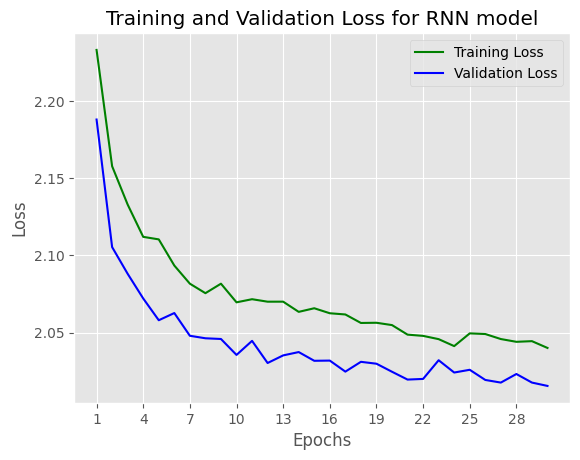

In [ ]:
# plot training & validation loss
n_epochs = range(1, epochs+1)
 
# Plot and label the training and validation loss values
# Use our custom style
plt.style.use('ggplot')
plt.plot(n_epochs, list_train_loss, 'g', label='Training Loss')
plt.plot(n_epochs, list_val_loss,  'b', label='Validation Loss')
 
# Add in a title and axes labels
plt.title('Training and Validation Loss for RNN model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
 
# Set the tick locations
plt.xticks(range(1, epochs+1, 3))
 
# Display the plot
plt.legend(loc='best')
plt.show()

**Comparing to LSTM model val loss (1.479) , GRU model val loss (1.513), RNN model val loss (2.015) is not good as 2 above models, it prove that RNN model is easy to be gradient vanishing.**

#### Text Generation using RNN

In [ ]:
# load the best checkpoint
model.load_state_dict(torch.load('best-RNN-model.pt'))

<All keys matched successfully>

In [ ]:
generate_text = text_generation(model, seq_length=500, input_text='story')

In [ ]:
generate_text

'story,’ se wal ane, what aid ther wof to maite and st one the washe tho gove mee shim, and tisht whathe toree tase, and at her hare, and harde hin timen to soo die, ‘Whar have aid one anoul to ther, ald tain so fors wis, he wile hares, and we tha gha butt he he are th there tore the bat hit watlit, hed her was se cound to kn the wirle th ter boo merang, an thous tere anding ono he anger, and harde the tall gat taind she said, ard wer welle, as wat then inther, and her the ser and har tore the so fan t'

###Conclusion

**LSTM Text Generating results:**

story winders; and as they were all sones towards to get out together for a bird singing, and was so to she had as tookingdown his wife; andhas she said tohimself, ‘If I can that was back to mark as have to stands.’ Then he went and looked another husband, but had brought in the child of the bride and croess. They said the peasants were all that he wished how it aspones that they could so, then he will go hometo her wood. Then the father had sicked a little sprong, help takeread any still the were to 

**GRU Text Generating results:**

story we that all sister on,but he wished to hear and crossed his word four huntsman. ‘Ah! would be all were aring, and as he should be seen for the tailor. When the well plated that he was to see the boat, and happened, that the father went totheir first. ‘And you were something with me to heapt as have breen the forest the stood, and set over he was asked him word to say, and she were to live and was asked how it, and therower she had saded asked him what the feast asked him for a sold, which saw th

**RNN Text Generating results:**

story,’ se wal ane, what aid ther wof to maite and st one the washe tho gove mee shim, and tisht whathe toree tase, and at her hare, and harde hin timen to soo die, ‘Whar have aid one anoul to ther, ald tain so fors wis, he wile hares, and we tha gha butt he he are th there tore the bat hit watlit, hed her was se cound to kn the wirle th ter boo merang, an thous tere anding ono he anger, and harde the tall gat taind she said, ard wer welle, as wat then inther, and her the ser and har tore the so fan t

**Conclusion**:  

1.   **After training LSTM, GRU and RNN for task text generation: RNN model result is not good as LSTM or GRU since RNN model faces vanishing gradient.**
2.   **GRU & LSTM achieved good results both for validation loss and text generating result.**

.

###Future Imporvement



1.   Text generation using Transfomer: a SOTA architecture for many domains such as NLP, Vision, Audio.
2.   Word-level approach
3.   Apply SOTA text generation pretrained model such as GPT-3.5 or BERT-family models

